In [17]:
%load_ext autoreload
%autoreload 2

# Ensure we can import "src.*" as a package
import sys, os, pathlib

# Try to locate repo root automatically
cwd = pathlib.Path.cwd()
if (cwd / "src").exists():
    REPO_ROOT = cwd
elif cwd.name == "src":   # if you are already inside the src dir
    REPO_ROOT = cwd.parent
else:
    REPO_ROOT = cwd  # fallback

SRC_DIR = REPO_ROOT / "src"
sys.path.insert(0, str(REPO_ROOT))
sys.path.insert(0, str(SRC_DIR))

# Make sure src is a package (safe if it already exists)
(SRC_DIR / "__init__.py").touch(exist_ok=True)

# === Imports (LM-only) ===
from src.lm_edges import build_from_ip_port_flow_csv
from src.models import GCN, LMEdgeHead
from src.model_utils import train_lm, infer_lm, eval_lm_edge

# Usual libs
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Flag so later cells can branch if needed
LM_ONLY = True


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Build LM-only dataset directly from CICIDS flows
from src.lm_edges import build_from_ip_port_flow_csv

lm_data = build_from_ip_port_flow_csv(
    csv_path="../datasets/public/CICIDS-2017.csv",
    src_ip_col="Source IP",
    dst_ip_col="Destination IP",
    src_port_col="Source Port",
    dst_port_col="Destination Port",
    label_col="Label",
    time_col=None,          # set to "Timestamp" if your CSV has it
    chunksize=200_000
)

print("Nodes:", lm_data.x.shape)
print("Edges:", lm_data.edge_index.shape)
print("Edge features:", None if lm_data.edge_attr is None else lm_data.edge_attr.shape)
print("Labels:", lm_data.y_edge.shape)
print("Train/Val/Test split:",
      int(lm_data.train_mask_edge.sum()),
      int(lm_data.val_mask_edge.sum()),
      int(lm_data.test_mask_edge.sum()))


Nodes: torch.Size([1027, 16])
Edges: torch.Size([2, 40500])
Edge features: torch.Size([40500, 11])
Labels: torch.Size([40500])
Train/Val/Test split: 28350 6075 6075


In [5]:
# statistics of the encoded attack graph
num_nodes = len(nodes)
print('num_nodes: ', num_nodes)

num_node_features = node_features.shape[1]
print('num_node_features: ', num_node_features)

num_edges = len(edges)
print('num_edges: ', num_edges)

action_nodes = corpus.get_action_nodes()
action_node_idx = list(action_nodes.keys())
num_action_nodes = len(action_node_idx)
print('action_node_idx: ', action_node_idx)
print('num_action_nodes: ', num_action_nodes)

# var 'action_mask' is used to represent the attack scenarios in attack graph (i.e., the privilege nodes)
action_mask = action_node_idx


num_nodes:  26
num_node_features:  57
num_edges:  26
action_node_idx:  [0, 2, 4, 7, 9, 12, 14]
num_action_nodes:  7


In [19]:
# Edge index from LM dataset is already built
print("Edge index shape:", lm_data.edge_index.shape)
print("First 5 edges (src -> dst):")
print(lm_data.edge_index[:, :5])


Edge index shape: torch.Size([2, 40500])
First 5 edges (src -> dst):
tensor([[0, 2, 4, 6, 8],
        [1, 3, 5, 7, 9]])


In [20]:
# LM-ONLY: derive handy aliases/splits from lm_data (edge-labeled)
# We DO NOT build Dataset-2 tensors here.

# Core tensors
x_nodes    = lm_data.x                  # [N_nodes, node_feat_dim]
edge_index = lm_data.edge_index         # [2, E]
edge_attr  = lm_data.edge_attr          # [E, edge_feat_dim] or None
y_edge     = lm_data.y_edge             # [E] (0/1)

# Split masks
train_mask = lm_data.train_mask_edge    # [E] bool
val_mask   = lm_data.val_mask_edge      # [E] bool
test_mask  = lm_data.test_mask_edge     # [E] bool

# Quick sanity/visibility
E = edge_index.shape[1]
print("Nodes:", x_nodes.shape, "| Edges:", E)
print("Edge feat dim:", None if edge_attr is None else edge_attr.shape[1])

n_pos_train = int(y_edge[train_mask].sum())
n_pos_val   = int(y_edge[val_mask].sum())
n_pos_test  = int(y_edge[test_mask].sum())
print("Positives per split  ->  train:", n_pos_train,
      " val:", n_pos_val, " test:", n_pos_test)

# If later cells accidentally expect the old names (X_train/Y_train/etc.),
# create lightweight aliases so the notebook doesn't crash.
# They won't be used by LM code, but keep them defined to avoid NameErrors.
X_train = X_val = X_test = None
Y_train = Y_val = Y_test = None
rt_meas_dim = None  # not applicable in LM edge classification


Nodes: torch.Size([1027, 16]) | Edges: 40500
Edge feat dim: 11
Positives per split  ->  train: 383  val: 101  test: 88


In [21]:
from src.public_data import load_LM_from_CICIDS

# Build LM-only edge dataset directly from CSV
lm_data = load_LM_from_CICIDS(
    csv_path="../datasets/public/CICIDS-2017.csv",
    time_col=None,   # or "Timestamp" if your CSV has it
    train_ratio=0.70,
    val_ratio=0.15,
)

# Handy aliases (LM uses edges, not node-dataset tensors)
x_nodes    = lm_data.x
edge_index = lm_data.edge_index
edge_attr  = lm_data.edge_attr
y_edge     = lm_data.y_edge
train_mask = lm_data.train_mask_edge
val_mask   = lm_data.val_mask_edge
test_mask  = lm_data.test_mask_edge

print(
    "Nodes:", x_nodes.shape,
    "\nEdges:", edge_index.shape,
    "\nEdge features:", None if edge_attr is None else edge_attr.shape,
    "\nLabels:", y_edge.shape,
)

# Quick split sanity
n_pos_train = int(y_edge[train_mask].sum())
n_pos_val   = int(y_edge[val_mask].sum())
n_pos_test  = int(y_edge[test_mask].sum())
print(f"Positives -> train: {n_pos_train}, val: {n_pos_val}, test: {n_pos_test}")


Nodes: torch.Size([1027, 16]) 
Edges: torch.Size([2, 40500]) 
Edge features: torch.Size([40500, 11]) 
Labels: torch.Size([40500])
Positives -> train: 383, val: 101, test: 88


In [22]:
# Hyperparameters for LM edge classification
in_dim        = lm_data.x.shape[1]
edge_feat_dim = 0 if lm_data.edge_attr is None else lm_data.edge_attr.shape[1]
hidden_dim    = 128
lr            = 1e-3
device        = "cpu"  # change to "cuda" if you have a GPU

# Backbone (embeddings are size = hidden_dim) + LM edge head (binary)
backbone = GCN(in_dim=in_dim, hidden_dim=hidden_dim, out_dim=64).to(device)
head     = LMEdgeHead(node_embed_dim=hidden_dim, edge_feat_dim=edge_feat_dim, hidden=128).to(device)

# Optimizer + focal-like BCE (helps class imbalance)
params     = list(backbone.parameters()) + list(head.parameters())
optimizer  = torch.optim.Adam(params, lr=lr, weight_decay=1e-4)

class BCEWithLogitsFocal(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha, self.gamma = alpha, gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, logits, targets):
        bce  = self.bce(logits, targets.float())
        prob = torch.sigmoid(logits)
        pt   = prob * targets + (1 - prob) * (1 - targets)
        return (self.alpha * (1 - pt)**self.gamma * bce).mean()

criterion = BCEWithLogitsFocal(alpha=0.25, gamma=2.0)

def _to_device():
    x = lm_data.x.to(device)
    ei = lm_data.edge_index.to(device)
    ea = lm_data.edge_attr.to(device) if lm_data.edge_attr is not None else None
    y  = lm_data.y_edge.to(device)
    tr = lm_data.train_mask_edge.to(device)
    va = lm_data.val_mask_edge.to(device)
    te = lm_data.test_mask_edge.to(device)
    return x, ei, ea, y, tr, va, te

# Training / evaluation loops
def train_epoch():
    backbone.train(); head.train()
    x, ei, ea, y, tr, _, _ = _to_device()
    z     = backbone.encode(x, ei)       # (N, D)
    z_src = z[ei[0]]                      # (E, D)
    z_dst = z[ei[1]]                      # (E, D)
    logits = head(z_src, z_dst, ea)      # (E,)

    loss = criterion(logits[tr], y[tr].float())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    return float(loss.item())

@torch.no_grad()
def eval_epoch(split='val'):
    backbone.eval(); head.eval()
    x, ei, ea, y, tr, va, te = _to_device()
    mask = va if split == 'val' else te
    z     = backbone.encode(x, ei)
    z_src = z[ei[0]]
    z_dst = z[ei[1]]
    logits = head(z_src, z_dst, ea)
    p = torch.sigmoid(logits[mask])
    y_s = y[mask]
    pred = (p >= 0.5).long()
    tp = int(((pred == 1) & (y_s == 1)).sum()); fp = int(((pred == 1) & (y_s == 0)).sum())
    fn = int(((pred == 0) & (y_s == 1)).sum())
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    return {"precision": precision, "recall": recall, "f1@0.5": f1, "logits": logits, "mask": mask}

# Train for a few epochs
best_f1 = -1.0
best_state = None
for epoch in range(1, 21):
    loss = train_epoch()
    m = eval_epoch('val')
    if m['f1@0.5'] > best_f1:
        best_f1   = m['f1@0.5']
        best_state = {'b': backbone.state_dict(), 'h': head.state_dict()}
    print(f"[LM] Epoch {epoch:03d}: loss={loss:.4f}  "
          f"P={m['precision']:.3f} R={m['recall']:.3f} F1={m['f1@0.5']:.3f}")

# Final test with best weights
if best_state is not None:
    backbone.load_state_dict(best_state['b']); head.load_state_dict(best_state['h'])

test_m = eval_epoch('test')
print("Final LM metrics:", {k: round(v,4) for k,v in test_m.items() if k in ('precision','recall','f1@0.5')})

# Save for later plotting cells
all_logits = test_m["logits"].detach().cpu()
test_mask  = test_m["mask"].detach().cpu()
y_test_e   = lm_data.y_edge[test_mask].cpu()
probs_test = torch.sigmoid(all_logits[test_mask]).cpu().numpy()


[LM] Epoch 001: loss=36495.6289  P=0.042 R=0.950 F1=0.081
[LM] Epoch 002: loss=6925.9263  P=0.096 R=0.505 F1=0.161
[LM] Epoch 003: loss=95.4917  P=0.195 R=0.416 F1=0.266
[LM] Epoch 004: loss=159.9445  P=0.291 R=0.406 F1=0.339
[LM] Epoch 005: loss=212.3088  P=0.000 R=0.000 F1=0.000
[LM] Epoch 006: loss=264.4172  P=0.000 R=0.000 F1=0.000
[LM] Epoch 007: loss=310.7181  P=0.000 R=0.000 F1=0.000
[LM] Epoch 008: loss=350.5229  P=0.000 R=0.000 F1=0.000
[LM] Epoch 009: loss=385.7801  P=0.000 R=0.000 F1=0.000
[LM] Epoch 010: loss=417.0182  P=0.000 R=0.000 F1=0.000
[LM] Epoch 011: loss=444.7464  P=0.000 R=0.000 F1=0.000
[LM] Epoch 012: loss=469.4023  P=0.000 R=0.000 F1=0.000
[LM] Epoch 013: loss=491.4031  P=0.000 R=0.000 F1=0.000
[LM] Epoch 014: loss=511.0699  P=0.000 R=0.000 F1=0.000
[LM] Epoch 015: loss=528.6690  P=0.000 R=0.000 F1=0.000
[LM] Epoch 016: loss=544.4299  P=0.000 R=0.000 F1=0.000
[LM] Epoch 017: loss=558.5417  P=0.000 R=0.000 F1=0.000
[LM] Epoch 018: loss=571.1711  P=0.000 R=0.000

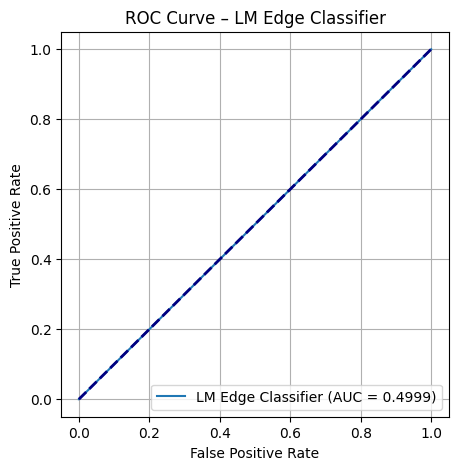

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_e.numpy(), probs_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"LM Edge Classifier (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LM Edge Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [24]:
# Reuse existing dataset if it already exists; otherwise build it
try:
    lm_data  # noqa: F821
except NameError:
    from src.lm_edges import build_from_ip_port_flow_csv  # package-safe import

    lm_data = build_from_ip_port_flow_csv(
        csv_path="../datasets/public/CICIDS-2017.csv",
        src_ip_col="Source IP",
        dst_ip_col="Destination IP",
        src_port_col="Source Port",      # ignored internally if missing
        dst_port_col="Destination Port",
        label_col="Label",
        time_col=None,                   # set "Timestamp" if your CSV has it
        chunksize=200_000
    )

# Sanity print
print(
    lm_data.x.shape,
    lm_data.edge_index.shape,
    (None if lm_data.edge_attr is None else lm_data.edge_attr.shape),
    lm_data.y_edge.shape
)


torch.Size([1027, 16]) torch.Size([2, 40500]) torch.Size([40500, 11]) torch.Size([40500])


In [26]:
from importlib import reload
import src.model_utils as mu
reload(mu)  # force-refresh to the latest file on disk

from src.models import GCN, LMEdgeHead
import torch

device = "cpu"

# Backbone + head
in_dim  = lm_data.x.shape[1]
hidden  = 128
backbone = GCN(in_dim=in_dim, hidden_dim=hidden, out_dim=hidden).to(device)

edge_feat_dim = 0 if lm_data.edge_attr is None else lm_data.edge_attr.shape[1]
lm_head = LMEdgeHead(node_embed_dim=hidden, edge_feat_dim=edge_feat_dim, hidden=128).to(device)

# Train (call via module to avoid stale symbols)
hist = mu.train_lm(
    backbone=backbone,
    lm_head=lm_head,
    data=lm_data,
    lr=1e-3,
    epochs=20,
    device=device,
    verbose=True
)

# Infer + evaluate
logits, y_edge = mu.infer_lm(backbone, lm_head, lm_data, device=device)
test_mask = lm_data.test_mask_edge if lm_data.test_mask_edge is not None else torch.ones_like(y_edge, dtype=torch.bool)
metrics = mu.eval_lm_edge(logits[test_mask], y_edge[test_mask], thresh=0.5)
print(metrics)


[LM] Epoch 001: loss=24848.4336 AUPRC=0.0166 F1=0.0000
[LM] Epoch 002: loss=19215.5625 AUPRC=0.0166 F1=0.0000
[LM] Epoch 003: loss=24604.1602 AUPRC=0.0166 F1=0.0000
[LM] Epoch 004: loss=21409.1172 AUPRC=0.0165 F1=0.0000
[LM] Epoch 005: loss=14135.5596 AUPRC=0.0161 F1=0.0000
[LM] Epoch 006: loss=6422.2886 AUPRC=0.0255 F1=0.0622
[LM] Epoch 007: loss=14206.0156 AUPRC=0.0330 F1=0.0927
[LM] Epoch 008: loss=9710.2354 AUPRC=0.0211 F1=0.0000
[LM] Epoch 009: loss=3922.9209 AUPRC=0.0230 F1=0.0000
[LM] Epoch 010: loss=6455.7393 AUPRC=0.0252 F1=0.0000
[LM] Epoch 011: loss=5429.7217 AUPRC=0.0300 F1=0.0000
[LM] Epoch 012: loss=1551.1997 AUPRC=0.0176 F1=0.0367
[LM] Epoch 013: loss=11047.1504 AUPRC=0.0951 F1=0.1721
[LM] Epoch 014: loss=685.9330 AUPRC=0.1812 F1=0.2286
[LM] Epoch 015: loss=3634.7463 AUPRC=0.1328 F1=0.3300
[LM] Epoch 016: loss=5618.5444 AUPRC=0.1291 F1=0.3257
[LM] Epoch 017: loss=5283.6157 AUPRC=0.1280 F1=0.3226
[LM] Epoch 018: loss=2899.4551 AUPRC=0.1658 F1=0.3180
[LM] Epoch 019: loss=6

In [27]:
df = pd.DataFrame([metrics]).round(4)
print(df.to_string(index=False))


  TN  FP  FN  TP  precision  recall     f1  roc_auc  auprc
5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778


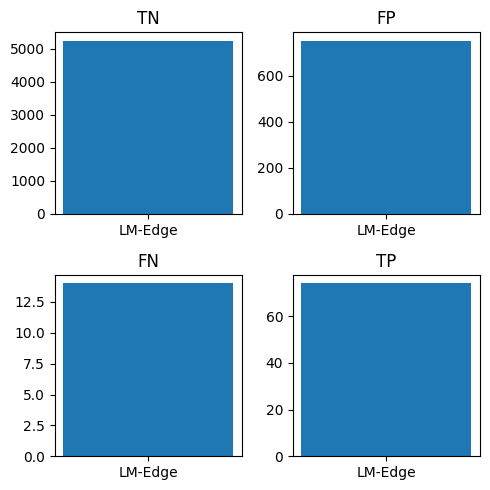

In [30]:
# Use values already returned by eval_lm_edge
metrics_ext = {k: metrics[k] for k in ["TN", "FP", "FN", "TP"]}

# Plot
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for i, label in enumerate(metrics_ext):
    axs[i].bar(0, metrics_ext[label], width=0.5, label="LM-Edge")
    axs[i].set_xticks([0])
    axs[i].set_xticklabels(["LM-Edge"])
    axs[i].set_title(label)

plt.tight_layout()
plt.show()


In [31]:
# --- LM-ONLY ROBUSTNESS EVALUATION ---
# We measure how metrics change when we add Gaussian noise to features.

import torch
import pandas as pd

backbone.eval(); lm_head.eval()  # use your trained models
device = next(backbone.parameters()).device

def eval_with_noise(std_x=0.0, std_ea=0.0):
    # copies so we don't modify lm_data
    x = lm_data.x.to(device).clone()
    ei = lm_data.edge_index.to(device)
    ea = lm_data.edge_attr.to(device).clone() if lm_data.edge_attr is not None else None
    y  = lm_data.y_edge.to(device)
    mask = lm_data.test_mask_edge.to(device).bool()

    # add noise
    if std_x > 0:
        x += torch.randn_like(x) * std_x
    if (ea is not None) and (std_ea > 0):
        ea += torch.randn_like(ea) * std_ea

    # forward
    with torch.no_grad():
        z = backbone.encode(x, ei)
        z_src, z_dst = z[ei[0]], z[ei[1]]
        logits = lm_head(z_src, z_dst, ea)

    from src.model_utils import eval_lm_edge  # safe import
    return eval_lm_edge(logits[mask], y[mask], thresh=0.5)

# Baseline and noisy settings
noise_grid = [
    {"std_x": 0.00, "std_ea": 0.00},
    {"std_x": 0.01, "std_ea": 0.00},
    {"std_x": 0.05, "std_ea": 0.00},
    {"std_x": 0.10, "std_ea": 0.00},
]
# include edge-attr noise if you have edge features
if lm_data.edge_attr is not None:
    noise_grid += [
        {"std_x": 0.00, "std_ea": 0.01},
        {"std_x": 0.00, "std_ea": 0.05},
        {"std_x": 0.01, "std_ea": 0.01},
        {"std_x": 0.05, "std_ea": 0.05},
    ]

rows = []
for cfg in noise_grid:
    m = eval_with_noise(**cfg)
    rows.append({
        "std_x": cfg["std_x"],
        "std_ea": cfg["std_ea"],
        "TN": m["TN"], "FP": m["FP"], "FN": m["FN"], "TP": m["TP"],
        "precision": round(m["precision"], 4),
        "recall": round(m["recall"], 4),
        "f1": round(m["f1"], 4),
        "roc_auc": round(m["roc_auc"], 4),
        "auprc": round(m["auprc"], 4),
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False))


 std_x  std_ea   TN  FP  FN  TP  precision  recall     f1  roc_auc  auprc
  0.00    0.00 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778
  0.01    0.00 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778
  0.05    0.00 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778
  0.10    0.00 5235 752  14  74     0.0896  0.8409 0.1619   0.8572 0.0778
  0.00    0.01 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778
  0.00    0.05 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778
  0.01    0.01 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778
  0.05    0.05 5236 751  14  74     0.0897  0.8409 0.1621   0.8572 0.0778



Top-10 suspicious edges (test split):
841 -> 7 | prob=1.000
1 -> 73 | prob=0.000
1 -> 199 | prob=0.000
1 -> 336 | prob=0.000
1 -> 356 | prob=0.000
1 -> 933 | prob=0.000
1 -> 958 | prob=0.000
2 -> 23 | prob=0.000
2 -> 42 | prob=0.000
2 -> 59 | prob=0.000


C:\Users\91984\AppData\Local\Temp\ipykernel_21788\251081329.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = cm.get_cmap("viridis")
d:\GNN-IDS\venv\Lib\site-packages\networkx\drawing\layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


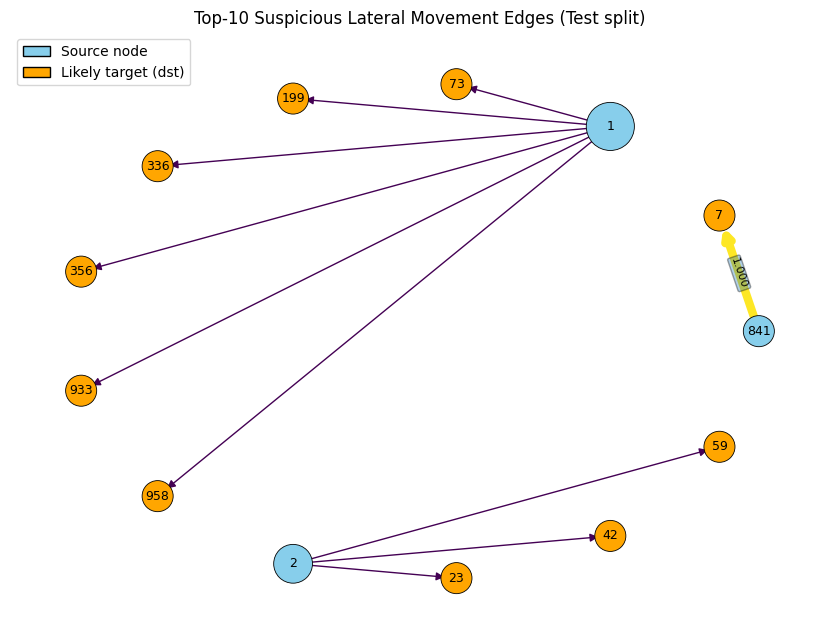

In [48]:
# === LM VIS: Top-10 suspicious edges — clean & readable (NumPy 2.x fix) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, networkx as nx, torch
from matplotlib import cm, colors
from matplotlib.patches import Patch

TOP_K      = 10         # number of edges to display
DECIMALS   = 3          # label precision
LABEL_TAU  = 0.01       # only label edges with prob >= LABEL_TAU
NODE_MIN   = 500        # min node size
NODE_MAX   = 1200       # max node size

# --- collect test probabilities ---
if "probs_test" in globals() and "y_test_e" in globals():
    p_test   = np.asarray(probs_test).reshape(-1)
    test_idx = np.nonzero(lm_data.test_mask_edge.cpu().numpy())[0]
elif "logits" in globals() and "y_edge" in globals() and hasattr(lm_data, "test_mask_edge"):
    tm       = lm_data.test_mask_edge
    p_test   = torch.sigmoid(logits[tm]).detach().cpu().numpy().reshape(-1)
    test_idx = np.nonzero(tm.cpu().numpy())[0]
else:
    raise RuntimeError("Run training first (need probs_test+y_test_e OR logits+y_edge+test_mask_edge).")

# --- dataframe of test edges + probs (dedup max per pair) ---
ei      = lm_data.edge_index.cpu().numpy()
src_ids = ei[0][test_idx]
dst_ids = ei[1][test_idx]
edge_df = (pd.DataFrame({"src_id": src_ids, "dst_id": dst_ids, "prob": p_test})
           .groupby(["src_id","dst_id"], as_index=False)["prob"].max()
           .sort_values("prob", ascending=False)
           .head(TOP_K))

# --- id->IP mapping (if available) ---
id2ip = None
for attr in ("id2ip", "node_id_to_ip", "ip_map"):
    if hasattr(lm_data, attr):
        m = getattr(lm_data, attr)
        id2ip = {int(k): v for k, v in (m.items() if isinstance(m, dict) else enumerate(m))}
        break
def node_label(n): return id2ip.get(int(n), str(int(n))) if id2ip is not None else str(int(n))

print("\nTop-10 suspicious edges (test split):")
for _, r in edge_df.iterrows():
    print(f"{node_label(r.src_id)} -> {node_label(r.dst_id)} | prob={r.prob:.{DECIMALS}f}")

# --- build subgraph ---
G = nx.DiGraph()
for _, r in edge_df.iterrows():
    G.add_edge(int(r.src_id), int(r.dst_id), weight=float(r.prob))

# node sizes by degree (within the shown subgraph)
deg = dict(G.degree())
dvals = np.array([deg[n] for n in G.nodes()], dtype=float)
if dvals.size > 0:
    dnorm = (dvals - dvals.min()) / (np.ptp(dvals) + 1e-6)
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * dnorm
else:
    node_sizes = NODE_MIN

# node colors: target (appears as dst) = orange, others = blue
dst_set = set(edge_df["dst_id"].tolist())
node_colors = ["#ffa600" if n in dst_set else "#87ceeb" for n in G.nodes()]
labels = {n: node_label(n) for n in G.nodes()}

# edge widths/colors by probability
probs = np.array([G[u][v]["weight"] for u, v in G.edges()], dtype=float)
if probs.size == 0: probs = np.array([0.0])
norm   = colors.Normalize(vmin=float(probs.min()), vmax=float(probs.max()) + 1e-12)
cmap   = cm.get_cmap("viridis")
e_cols = [cmap(norm(w)) for w in probs]
e_wids = 1.0 + 5.0 * (probs - probs.min()) / (np.ptp(probs) + 1e-6)

# layout
plt.figure(figsize=(8.5, 6.5))
pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                       edgecolors="black", linewidths=0.6)
nx.draw_networkx_edges(G, pos, width=e_wids, edge_color=e_cols,
                       arrowsize=12, arrowstyle='-|>')

nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

# label only edges with prob >= LABEL_TAU
fmt = f"{{:.{DECIMALS}f}}"
edge_labels = {(u, v): fmt.format(G[u][v]["weight"])
               for u, v in G.edges() if G[u][v]["weight"] >= LABEL_TAU}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8,
                             bbox=dict(alpha=0.35, boxstyle="round,pad=0.15"))

# legend
legend_handles = [
    Patch(facecolor="#87ceeb", edgecolor="black", label="Source node"),
    Patch(facecolor="#ffa600", edgecolor="black", label="Likely target (dst)"),
]
plt.legend(handles=legend_handles, loc="upper left", frameon=True)

plt.title("Top-10 Suspicious Lateral Movement Edges (Test split)")
plt.axis("off"); plt.tight_layout(); plt.show()
